In [2]:
import numpy as np
import os 
import time
import pickle

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.visualize import visCircles, visForces

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140
plt.rcParams["font.size"] = 13

In [138]:
syntheticFolder = '../'
dataSet = '2022-03-29_Medium_Synthetic_0/'

pIndex = 3

In [126]:
with open(syntheticFolder + dataSet + 'forces.pickle', 'rb') as f:
    forceArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'betas.pickle', 'rb') as f:
    betaArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'alphas.pickle', 'rb') as f:
    alphaArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'centers.pickle', 'rb') as f:
    centerArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'radii.pickle', 'rb') as f:
    radiusArr = pickle.load(f)
with open(syntheticFolder + dataSet + 'angles.pickle', 'rb') as f:
    angleArr = pickle.load(f)

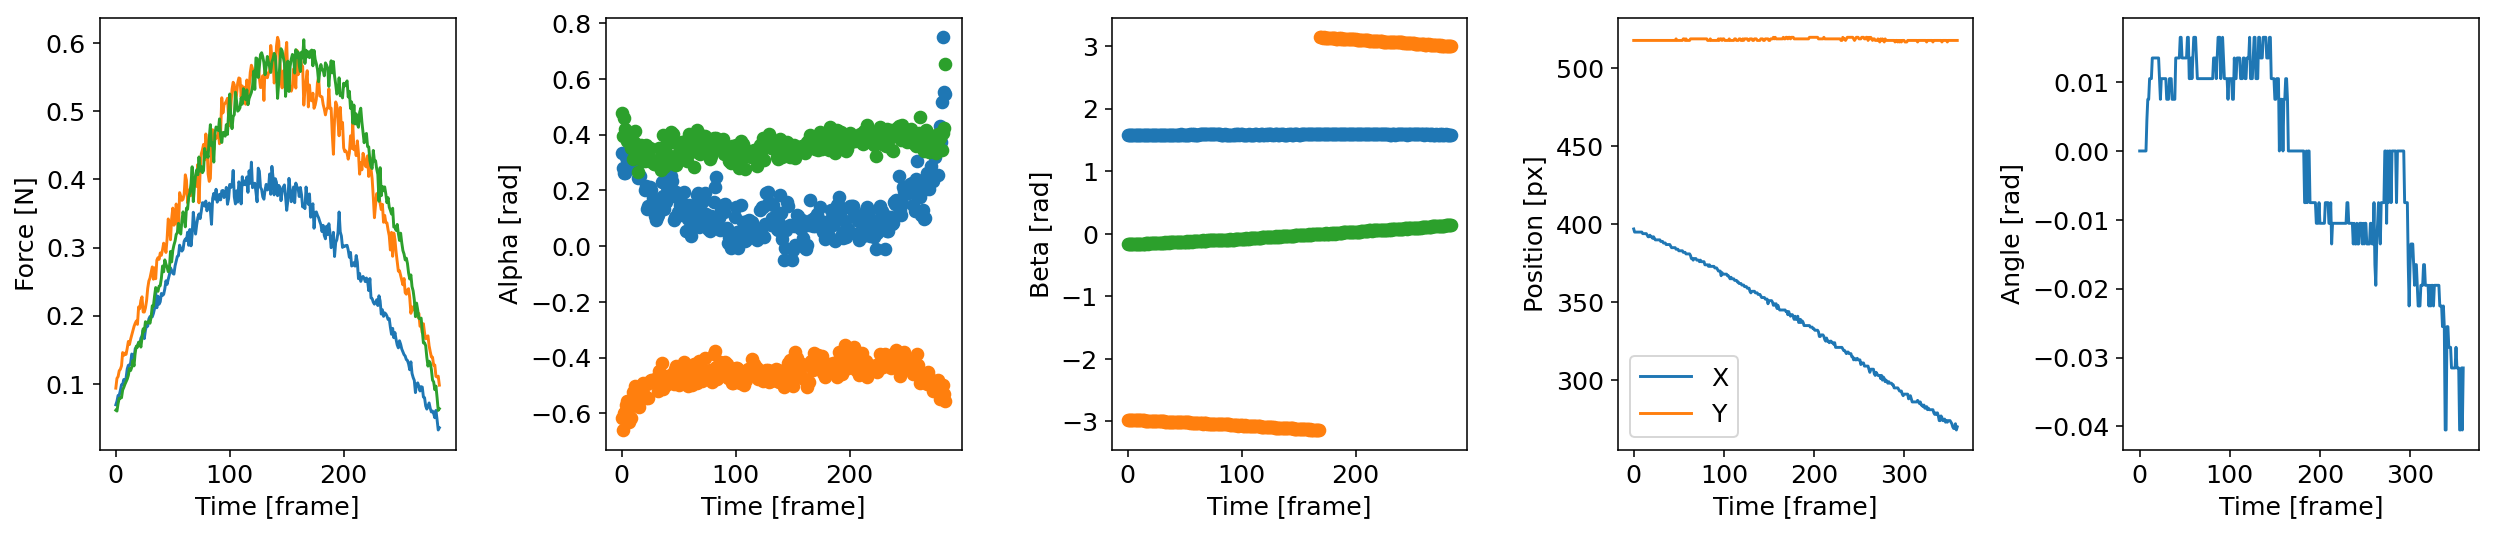

In [139]:
fig, ax = visForces(forceArr[pIndex], alphaArr[pIndex], betaArr[pIndex], centerArr[pIndex], angleArr[pIndex])

#fig.tight_layout()
plt.show()

In [227]:
def polarToCartesianForces(forceMagArr, alphaArr, betaArr):
    """
    Split each force, provided in the angular frame of each particle
    (alphas and betas) into x and y components.
    
    Parameters
    ----------
    
    forceMagArr : np.ndarray[F,T]
        Magnitude of F forces acting on the particle for T timesteps 
    """
    
    cartesianForceArr = np.zeros((*forceMagArr.shape, 2))
    # Assume only a single particle is passed in
    for i in range(forceMagArr.shape[0]):
        for j in range(forceMagArr.shape[1]):
            # F_x
            cartesianForceArr[i,j,1] = -forceMagArr[i,j] * np.sin(-alphaArr[i,j] + betaArr[i,j]) #(-np.sin(betaArr[i,j]) * np.cos(alphaArr[i,j]) + np.cos(betaArr[i,j]) * np.sin(alphaArr[i,j]))
            # F_y
            cartesianForceArr[i,j,0] = forceMagArr[i,j] * np.cos(-alphaArr[i,j] + betaArr[i,j]) #(np.cos(betaArr[i,j]) * np.cos(alphaArr[i,j]) + np.sin(betaArr[i,j]) * np.sin(alphaArr[i,j]))
        
    return cartesianForceArr

In [233]:
xyForceArr = polarToCartesianForces(forceArr[pIndex], alphaArr[pIndex], betaArr[pIndex])
#xyForceArr = polarToCartesianForces(forceArr[pIndex], np.zeros_like(alphaArr[pIndex]), betaArr[pIndex])

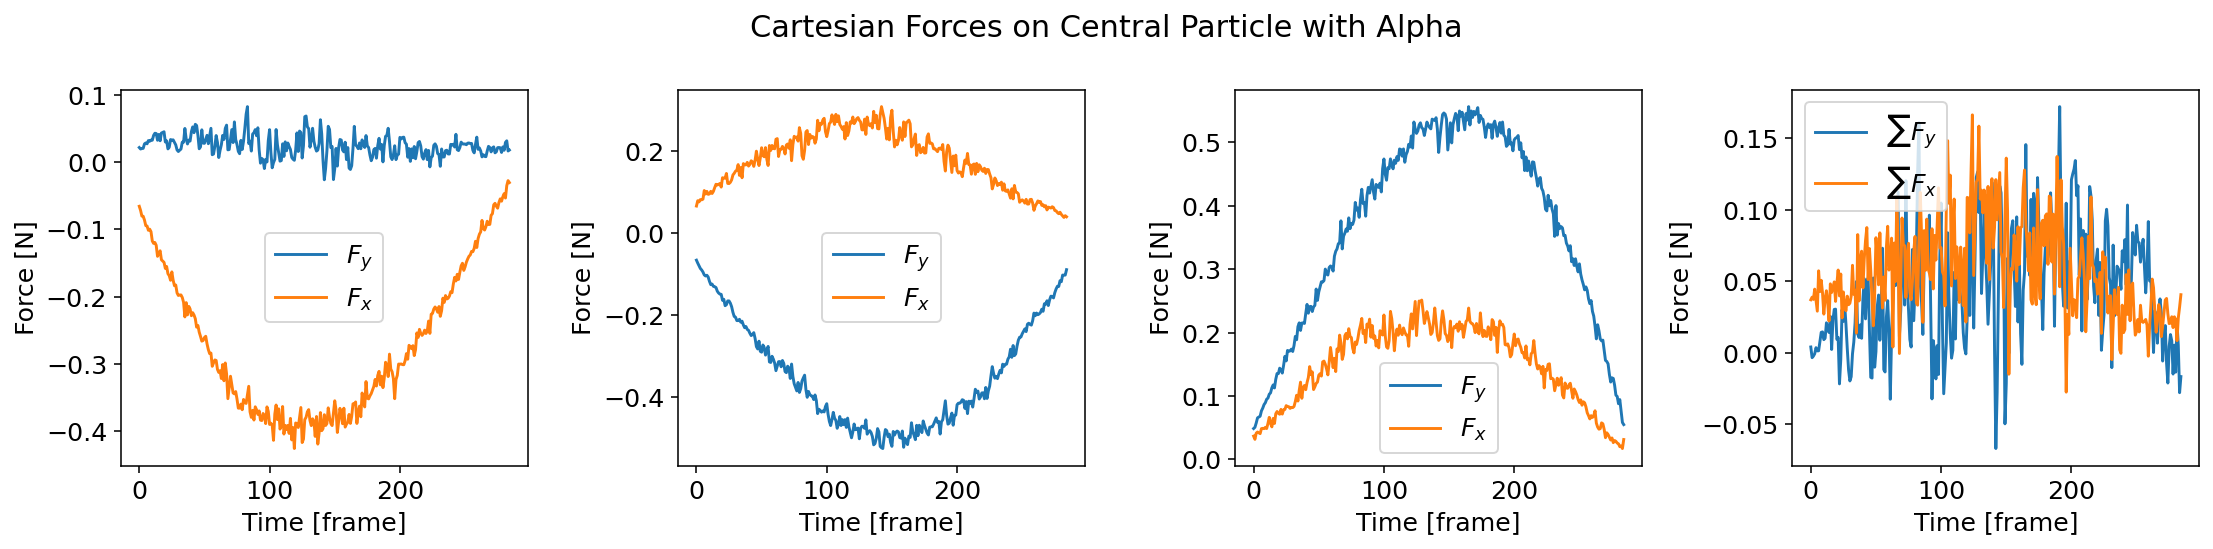

In [234]:
fig, ax = plt.subplots(1, len(forceArr[pIndex])+1, figsize=(16,4))

for i in range(len(forceArr[pIndex])):
    ax[i].plot(xyForceArr[i,:,0], label=r'$F_y$')
    ax[i].plot(xyForceArr[i,:,1], label=r'$F_x$')
    ax[i].legend()

# Sum up all x forces
xForceSumArr = np.sum(xyForceArr[:,:,1], axis=0)
yForceSumArr = np.sum(xyForceArr[:,:,0], axis=0)

ax[-1].plot(yForceSumArr, label=r'$\sum F_y$')
ax[-1].plot(xForceSumArr, label=r'$\sum F_x$')
ax[-1].legend()

for i in range(len(ax)):
    ax[i].set_xlabel('Time [frame]')
    ax[i].set_ylabel('Force [N]')

fig.suptitle('Cartesian Forces on Central Particle with Alpha')
fig.tight_layout()
#plt.savefig('../images/cartesian_force_with_alpha.png')
plt.show()